In [1]:
from vocabulary import Vocabulary

vocab_threshold = 4
vocab = Vocabulary(vocab_threshold=vocab_threshold)

embed_size = 256
hidden_size = 512
vocab_size = len(vocab) 
num_epochs = 5

model_dir = './models'
encoder_file = 'encoder-%d.pkl' % num_epochs
decoder_file = 'decoder-%d.pkl' % num_epochs

In [2]:
%load_ext autoreload
% autoreload 2

In [3]:
import os
import torch
from model import EncoderCNN, DecoderRNN

encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

encoder.load_state_dict(torch.load(os.path.join(model_dir, encoder_file)))
decoder.load_state_dict(torch.load(os.path.join(model_dir, decoder_file)))

if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

In [4]:
from pycocotools.coco import COCO

val_dir = '../cocoapi/images/val2014/'
coco = COCO('../cocoapi/annotations/captions_val2014.json')

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


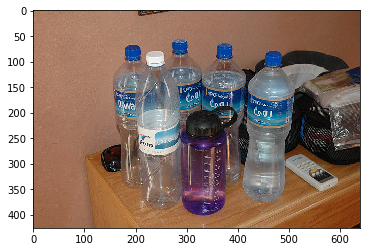

Original caption: An assortment of water bottles arranged on a night side table.


In [5]:
import random
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])

ann_id = random.sample(list(coco.anns.keys()), 1)[0]
img_id = coco.anns[ann_id]['image_id']
image_path = coco.loadImgs(img_id)[0]['file_name']
caption = coco.anns[ann_id]['caption']

image = Image.open(os.path.join(val_dir, image_path)).convert('RGB')
# display image
plt.imshow(image)
plt.show()
print('Original caption:', caption)

image_tensor = transform_val(image).unsqueeze(0)

In [6]:
import torch
from torch.autograd import Variable

def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)

image_var = to_var(image_tensor, volatile=True)

In [10]:
features = encoder(image_var)
output = decoder.sample(feature)
output = output.cpu().data.numpy()

AttributeError: 'NoneType' object has no attribute 'cpu'

In [36]:
sampled_ids = []
inputs = features.unsqueeze(1) # 1 x 1 x 256
states = None

for i in range(20):
    hiddens, states = decoder.lstm(inputs, states)
    outputs = decoder.linear(hiddens.squeeze(1))
    predicted = outputs.max(1)[1]
    sampled_ids.append(predicted.data[0])
    inputs = decoder.embed(predicted)
    inputs = inputs.unsqueeze(1)
sampled_ids = torch.Tensor(sampled_ids)

print(sampled_ids)


    1
 1774
  561
 5226
 1774
  561
 8822
 1774
  561
 2509
 1655
 3722
    2
    2
    2
    2
    2
    2
    2
    2
[torch.FloatTensor of size 20]

